In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Burgers Equation Data Generation

In [ ]:
import numpy as np
import torch
from scipy.integrate import odeint
from tqdm import tqdm

# Constants for data generation
nu = 0.01  # Kinematic viscosity coefficient

# Spatial mesh
L_x = 10  # Domain length
dx = 0.01  # Infinitesimal spatial step
N_x = int(L_x / dx)
X = np.linspace(0, L_x, N_x)  # Spatial array

# Temporal mesh
L_t = 8  # Simulation duration
dt = 0.025  # Time step
N_t = int(L_t / dt)
T = np.linspace(0, L_t, N_t)  # Temporal array

# Wave number discretization
k = 2 * np.pi * np.fft.fftfreq(N_x, d=dx)

# Burgers' system definition
def burg_system(u, t, k, mu, nu):
    u_hat = np.fft.fft(u)
    u_hat_x = 1j * k * u_hat
    u_hat_xx = -k**2 * u_hat
    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)
    u_t = -mu * u * u_x + nu * u_xx
    return u_t.real

# Data generation
num_samples = 100  # Number of samples for NN training
training_data = []

for _ in tqdm(range(num_samples), desc="Generating Training Data"):
    mu = np.random.uniform(0.5, 1.5)  # Random mu in [0.5, 1.5]
    m = np.random.uniform(2, 4)  # Random m in [2, 4]

    # Initial condition
    u0 = np.exp(-(X - m)**2 / 2)

    # Solve the PDE
    U = odeint(burg_system, u0, T, args=(k, mu, nu), mxstep=5000).T

    # Store the data for training
    training_data.append({
        'mu': torch.tensor([[mu]], dtype=torch.float32),
        'm': torch.tensor([[m]], dtype=torch.float32),
        'x': torch.tensor(X, dtype=torch.float32),
        't': torch.tensor(T, dtype=torch.float32),
        'U': torch.tensor(U, dtype=torch.float32)
    })

# Data generation is complete


Generating Training Data:  89%|████████▉ | 89/100 [28:36<03:08, 17.12s/it]

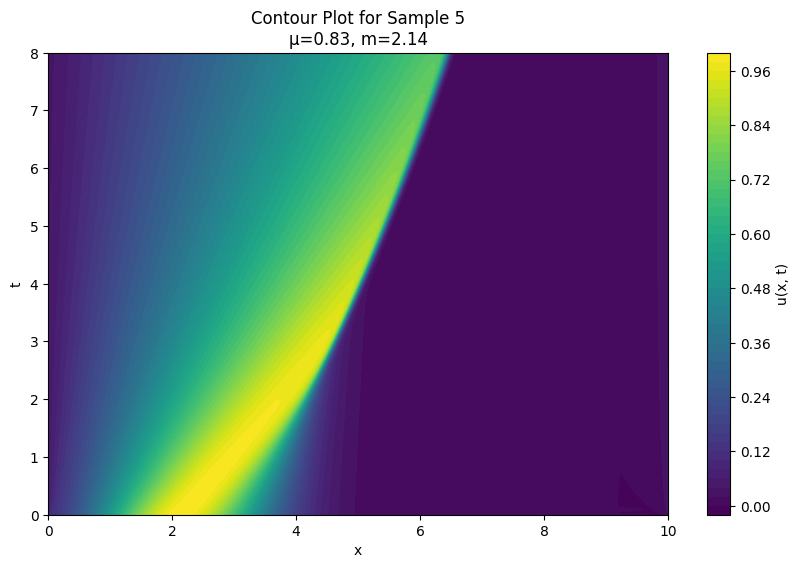

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the sample index to visualize
sample_index = 4  # Change this index to visualize a different sample

# Extract the sample
sample = training_data[sample_index]
x = sample['x'].numpy()
t = sample['t'].numpy()
U = sample['U'].numpy()
mu = sample['mu'].item()  # Extract mu value
m = sample['m'].item()    # Extract m value

# Create a contourf plot
plt.figure(figsize=(10, 6))
X, T = np.meshgrid(x, t)
plt.contourf(X, T, U.T, levels=50, cmap='viridis')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Contour Plot for Sample {sample_index + 1}\nμ={mu:.2f}, m={m:.2f}')
plt.show()


In [1]:
import numpy as np
import torch
from scipy.integrate import odeint
from tqdm import tqdm

# Constants for data generation
nu = 0.01  # Kinematic viscosity coefficient

# Spatial mesh
L_x = 10  # Domain length
dx = 0.01  # Infinitesimal spatial step
N_x = int(L_x / dx)
X = np.linspace(0, L_x, N_x)  # Spatial array

# Temporal mesh
L_t = 8  # Simulation duration
dt = 0.025  # Time step
N_t = int(L_t / dt)
T = np.linspace(0, L_t, N_t)  # Temporal array

# Wave number discretization
k = 2 * np.pi * np.fft.fftfreq(N_x, d=dx)

# Burgers' system definition
def burg_system(u, t, k, mu, nu):
    u_hat = np.fft.fft(u)
    u_hat_x = 1j * k * u_hat
    u_hat_xx = -k**2 * u_hat
    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)
    u_t = -mu * u * u_x + nu * u_xx
    return u_t.real

# Data generation
num_samples = 20  # Number of samples for NN training
testing_data = []

for _ in tqdm(range(num_samples), desc="Generating Testing Data"):
    mu = np.random.uniform(0.5, 1.5)  # Random mu in [0.5, 1.5]
    m = np.random.uniform(2, 4)  # Random m in [2, 4]

    # Initial condition
    u0 = np.exp(-(X - m)**2 / 2)

    # Solve the PDE
    U = odeint(burg_system, u0, T, args=(k, mu, nu), mxstep=5000).T

    # Store the data for training
    testing_data.append({
        'mu': torch.tensor([[mu]], dtype=torch.float32),
        'm': torch.tensor([[m]], dtype=torch.float32),
        'x': torch.tensor(X, dtype=torch.float32),
        't': torch.tensor(T, dtype=torch.float32),
        'U': torch.tensor(U, dtype=torch.float32)
    })

# Data generation is complete

Generating Testing Data: 100%|██████████| 20/20 [12:04<00:00, 36.20s/it]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tqdm import tqdm  # Import tqdm for the progress bar
import pickle


nu = 0.01  # Kinematic viscosity coefficient

# Define the neural network architecture
class ControlPointNet(nn.Module):
    def __init__(self, n_cp_x, n_cp_t, hidden_dim=64):
        super(ControlPointNet, self).__init__()
        self.fc1 = nn.Linear(2, hidden_dim)  # 2 inputs: lambda_param and a
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, (n_cp_x) * (n_cp_t))

    def forward(self, mu, m):
        x = torch.cat((mu, m), dim=1)  # Concatenate inputs
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(n_cp_t, n_cp_x)

# B-spline basis function
def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if Ln[i - 1] <= t < Ln[i] else 0.0
    else:
        a = 0 if (Ln[d + i - 1] - Ln[i - 1]) == 0 else (t - Ln[i - 1]) / (Ln[d + i - 1] - Ln[i - 1])
        b = 0 if (Ln[d + i] - Ln[i]) == 0 else (Ln[d + i] - t) / (Ln[d + i] - Ln[i])
        return a * BsFun(i, d - 1, t, Ln) + b * BsFun(i + 1, d - 1, t, Ln)

# B-spline derivative basis function (first derivative)
def BsFun_derivative(i, d, t, Ln):
    if d == 0:
        return 0.0
    else:
        a = 0 if (Ln[d + i - 1] - Ln[i - 1]) == 0 else d / (Ln[d + i - 1] - Ln[i - 1])
        b = 0 if (Ln[d + i] - Ln[i]) == 0 else d / (Ln[d + i] - Ln[i])
        return a * BsFun(i, d - 1, t, Ln) - b * BsFun(i + 1, d - 1, t, Ln)

# Second derivative of B-spline
def BsFun_second_derivative(i, d, t, Ln):
    if d < 2:
        return 0.0
    else:
        a = 0 if (Ln[d + i - 2] - Ln[i - 2]) == 0 else d * (d - 1) / ((Ln[d + i - 2] - Ln[i - 2]) ** 2)
        b = 0 if (Ln[d + i - 1] - Ln[i - 1]) == 0 else 2 * d * (d - 1) / ((Ln[d + i - 1] - Ln[i - 1]) ** 2)
        c = 0 if (Ln[d + i] - Ln[i]) == 0 else d * (d - 1) / ((Ln[d + i] - Ln[i]) ** 2)
        return a * BsFun(i, d - 2, t, Ln) - b * BsFun(i + 1, d - 2, t, Ln) + c * BsFun(i + 2, d - 2, t, Ln)

# B-spline knots and basis matrix
def BsKnots(n_cp, d, Ns):
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots)

    # Construct the knots vector
    for i in range(d + 1, n_knots - d - 1):
        Ln[i] = i - d
    Ln[n_knots - d - 1:] = n_cp - d  # The last d+1 elements should be the same

    # Parameter vector (linearly spaced)
    tk = np.zeros(Ns)
    for i in range(1, Ns):
        tk[i] = tk[i - 1] + Ln[-1] / (Ns - 1)

    # B-spline basis matrix
    Bit = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j + 1, d, tk[i], Ln)

    Bit[Ns - 1, n_cp - 1] = 1
    return tk, Ln, Bit

# Compute B-spline basis matrix derivatives
def BsKnots_derivatives(n_cp, d, Ns, Ln, tk):
    # First derivative
    Bit_derivative = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit_derivative[i, j] = BsFun_derivative(j + 1, d, tk[i], Ln)

    # Second derivative
    Bit_second_derivative = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit_second_derivative[i, j] = BsFun_second_derivative(j + 1, d, tk[i], Ln)

    return Bit_derivative, Bit_second_derivative

# Ground truth function based on your working code
def ground_truth(x_vals, T_vals, a, lambda_param):
    def f(x, t, a, lambda_param):
        if t == 0:
            return 0
        return (a - x) / np.sqrt(2 * np.pi * t**3) * np.exp(-((a - x) - lambda_param * t) ** 2 / (2 * t))

    def F2(x, T, a, lambda_param):
        if x >= a:  # already in safe set
            return 1
        else:
            result, _ = quad(lambda t: f(x, t, a, lambda_param), 0, T)
            return result

    F = np.zeros((len(T_vals), len(x_vals)))
    for i, xi in enumerate(x_vals):
        for j, Tj in enumerate(T_vals):
            F[j, i] = F2(xi, Tj, a, lambda_param)

    return F

# Compute derivatives of B-spline surfaces
def compute_bspline_derivatives(U_full, Bit_t, Bit_x, Bit_t_derivative, Bit_x_derivative, Bit_t_second_derivative, Bit_x_second_derivative):
    # First derivative with respect to time t (using first derivative of Bit_t)
    B_surface_t = torch.matmul(torch.matmul(Bit_t_derivative, U_full), Bit_x.T)

    # First derivative with respect to space x (using first derivative of Bit_x)
    B_surface_x = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x_derivative.T)

    # Second derivative with respect to space x (using second derivative of Bit_x)
    B_surface_xx = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x_second_derivative.T)

    return B_surface_t, B_surface_x, B_surface_xx

# Initialize parameters
n_cp_t = 100  # number of control points in time
n_cp_x = 100  # number of control points in state
d = 4  # order of B-spline
hidden_dim = 64  # Hidden dimension size
num_samples = 100  # Number of different lambda and a pairs to precompute

# Create neural network
model = ControlPointNet(n_cp_x, n_cp_t, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

L_x = 10 # Range of the domain according to x [m]
dx = 0.01 # Infinitesimal distance
Nx = int(L_x/dx) # Points number of the spatial mesh
x = np.linspace(0, L_x, Nx) # Spatial array

L_t = 8 # Duration of simulation [s]
dt = 0.025  # Infinitesimal time
Nt = int(L_t/dt) # Points number of the temporal mesh    # Includes endpoint
t = np.linspace(0, L_t, Nt) # Temporal array

# Generate B-spline basis matrices for x
tk_x, Ln_x, Bit_x = BsKnots(n_cp_x, d, Nx)
Bit_x_derivative, Bit_x_second_derivative = BsKnots_derivatives(n_cp_x, d, Nx, Ln_x, tk_x)

# Convert B-spline matrices for x to PyTorch tensors
Bit_x = torch.tensor(Bit_x, dtype=torch.float32)
Bit_x_derivative = torch.tensor(Bit_x_derivative, dtype=torch.float32)
Bit_x_second_derivative = torch.tensor(Bit_x_second_derivative, dtype=torch.float32)

with open('/content/drive/MyDrive/DeepONet/Data/burgers_training_data.pkl', 'rb') as f:
    loaded_training_data = pickle.load(f)

# Precompute Training Data
training_data = []
for i in range(num_samples):
    # Randomly select a value of a and lambda in their respective ranges
    sample = loaded_training_data[i]
    mu = sample['mu']
    m = sample['m']
    U = sample['U']

    # Store the data in the list
    training_data.append({
        'mu': mu,
        'm': m,
        'U': U,
        'Bit_x': Bit_x,
        'Bit_x_derivative': Bit_x_derivative,
        'Bit_x_second_derivative': Bit_x_second_derivative
    })

# Generate B-spline basis matrices for time (these are constant)
tk_t, Ln_t, Bit_t = BsKnots(n_cp_t, d, Nt)
Bit_t_derivative, Bit_t_second_derivative = BsKnots_derivatives(n_cp_t, d, Nt, Ln_t, tk_t)
Bit_t = torch.tensor(Bit_t, dtype=torch.float32)
Bit_t_derivative = torch.tensor(Bit_t_derivative, dtype=torch.float32)
Bit_t_second_derivative = torch.tensor(Bit_t_second_derivative, dtype=torch.float32)

### Burgers Equation Data Generation

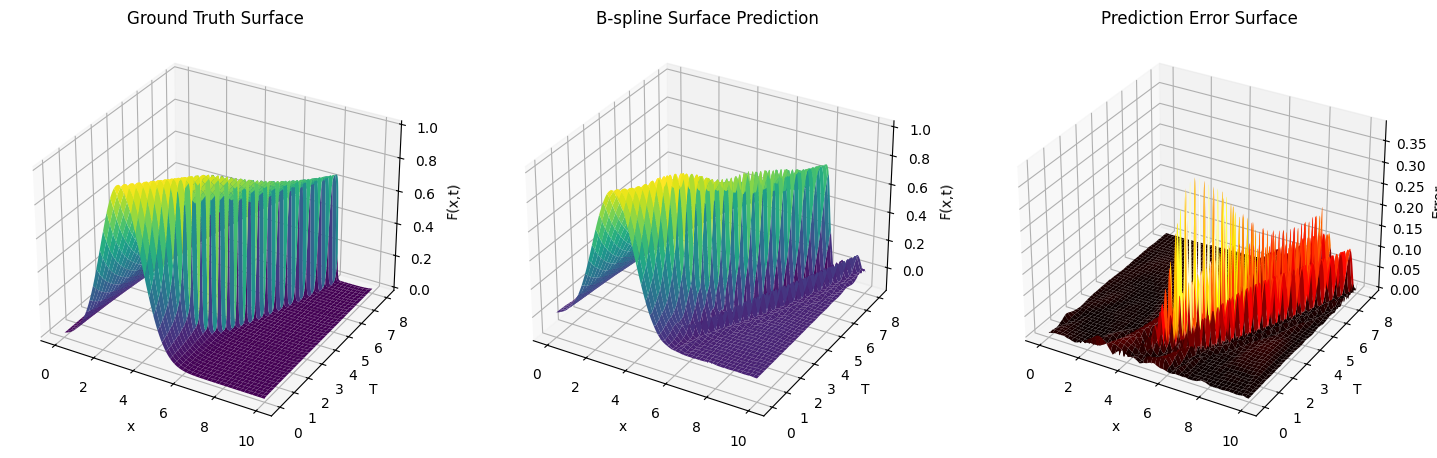

In [ ]:
import matplotlib.pyplot as plt

sample_index = 14  # Change this index to visualize a different sample

# Extract the sample
sample = testing_data[sample_index]
sample = training_data[sample_index]

mu_test = sample['mu'].item()  # Extract mu value
m_test = sample['m'].item()    # Extract m value
# Ground truth data for testing
U_test = sample['U'].numpy().T

# Predict control points for the test lambda and a values
mu_tensor_test = torch.tensor([[mu_test]], dtype=torch.float32)
m_tensor_test = torch.tensor([[m_test]], dtype=torch.float32)
U_test_pred = model(mu_tensor_test, m_tensor_test).detach().numpy()

# # Construct the full control point matrix for the new lambda and a
U_test_full = U_test_pred 

# Generate the B-spline surface with the predicted control points
B_surface_test = torch.matmul(torch.matmul(Bit_t, torch.tensor(U_test_full, dtype=torch.float32)), Bit_x.T).detach().numpy()

# Compute the prediction error
error_surface = np.abs(B_surface_test - U_test)

# Plot the predicted B-spline surface, ground truth, and error
fig = plt.figure(figsize=(18, 6))

# Plot the ground truth surface
ax0 = fig.add_subplot(131, projection='3d')
X, Y = np.meshgrid(x, t)
ax0.plot_surface(X, Y, U_test, cmap='viridis', edgecolor='none')
ax0.set_title('Ground Truth Surface')
ax0.set_xlabel('x')
ax0.set_ylabel('T')
ax0.set_zlabel('F(x,t)')

# Plot the predicted B-spline surface
ax1 = fig.add_subplot(132, projection='3d')
ax1.plot_surface(X, Y, B_surface_test, cmap='viridis', edgecolor='none')
ax1.set_title('B-spline Surface Prediction')
ax1.set_xlabel('x')
ax1.set_ylabel('T')
ax1.set_zlabel('F(x,t)')

# Plot the prediction error
ax2 = fig.add_subplot(133, projection='3d')
ax2.plot_surface(X, Y, error_surface, cmap='hot', edgecolor='none')
ax2.set_title('Prediction Error Surface')
ax2.set_xlabel('x')
ax2.set_ylabel('T')
ax2.set_zlabel('Error')

plt.show()

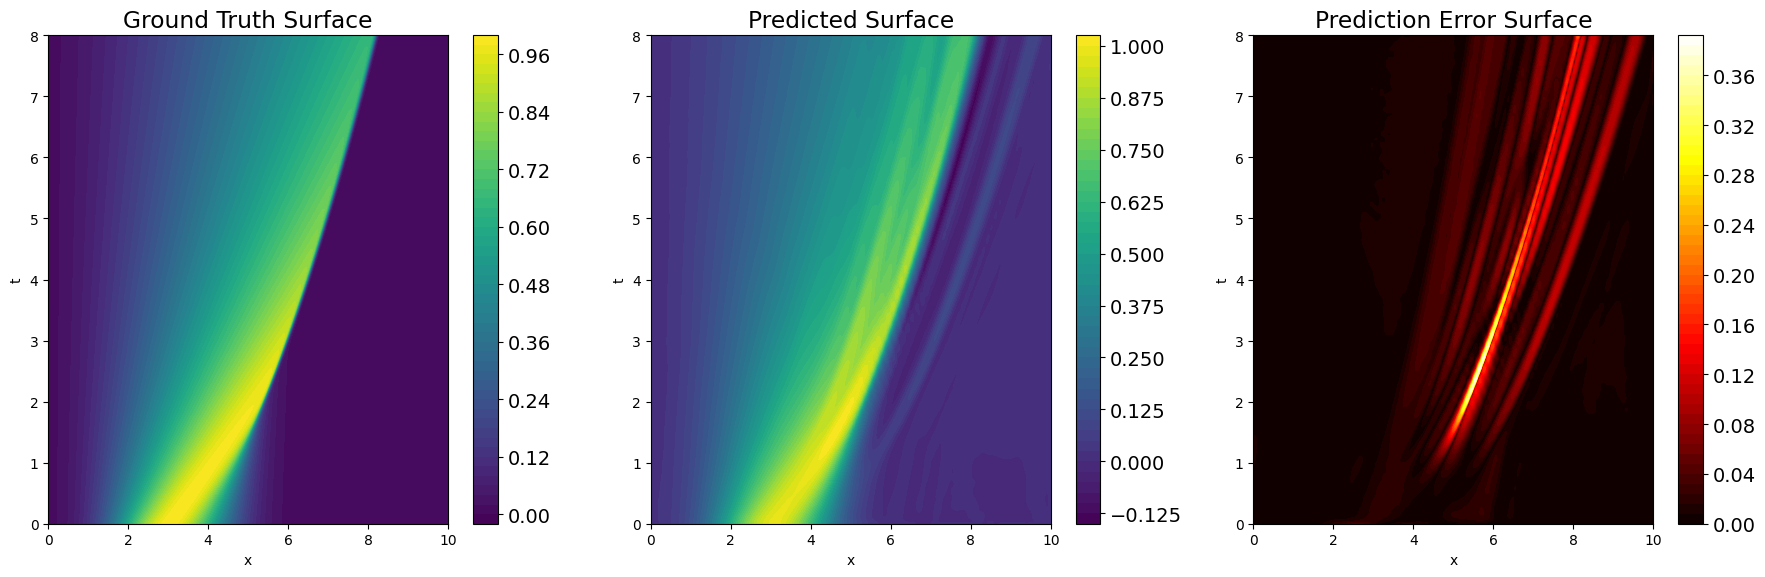

In [ ]:
# Plot using contourf
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plt.rcParams.update({'font.size': 14})

# Ground truth surface
contour0 = axes[0].contourf(X, Y, U_test, levels=50, cmap='viridis')
plt.colorbar(contour0, ax=axes[0])
axes[0].set_title('Ground Truth Surface')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')

# Predicted B-spline surface
contour1 = axes[1].contourf(X, Y, B_surface_test, levels=50, cmap='viridis')
plt.colorbar(contour1, ax=axes[1])
axes[1].set_title('Predicted Surface')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')

# Error surface
contour2 = axes[2].contourf(X, Y, error_surface, levels=50, cmap='hot')
plt.colorbar(contour2, ax=axes[2])
axes[2].set_title('Prediction Error Surface')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')

plt.tight_layout()

plt.show()

In [ ]:
np.mean(error_surface)

np.float32(0.016545143)

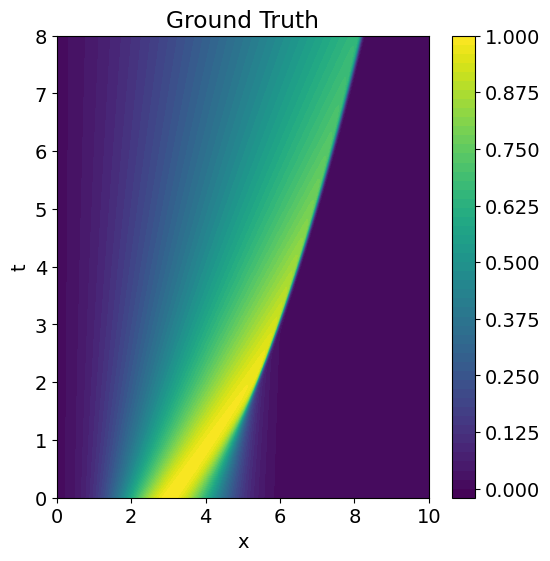

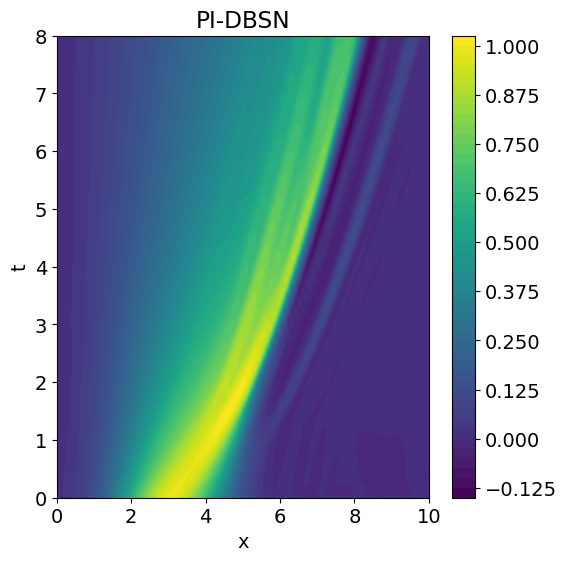

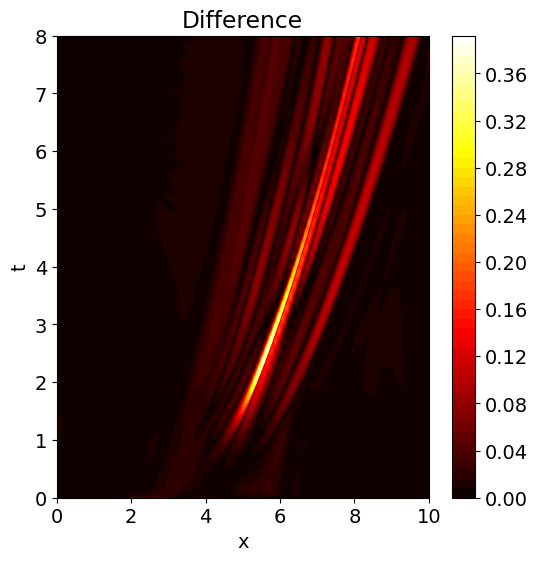

In [ ]:
import matplotlib.pyplot as plt

# Set larger font size for better readability
plt.rcParams.update({'font.size': 14})

# Plot 1: Ground truth surface
fig1, ax1 = plt.subplots(figsize=(6, 6))
contour0 = ax1.contourf(X, Y, U_test, levels=50, cmap='viridis')
cbar1 = plt.colorbar(contour0, ax=ax1)
cbar1.set_ticks(np.linspace(0, 1, 9))  # Set color legend ticks
ax1.set_title('Ground Truth')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

# Plot 2: Predicted B-spline surface
fig2, ax2 = plt.subplots(figsize=(6, 6))
contour1 = ax2.contourf(X, Y, B_surface_test, levels=50, cmap='viridis')
plt.colorbar(contour1, ax=ax2)
ax2.set_title('PI-BSNet')
ax2.set_xlabel('x')
ax2.set_ylabel('t')

# Plot 3: Error surface
fig3, ax3 = plt.subplots(figsize=(6, 6))
contour2 = ax3.contourf(X, Y, error_surface, levels=50, cmap='hot')
plt.colorbar(contour2, ax=ax3)
ax3.set_title('Difference')
ax3.set_xlabel('x')
ax3.set_ylabel('t')

plt.show()


### Error Statistics

In [ ]:
error_mae = np.zeros(20)
error_l2 = np.zeros(20)
error_rel_l2 = np.zeros(20)

for sample_index in range(20):

    # Extract the sample
    sample = testing_data[sample_index]

    mu_test = sample['mu'].item()
    m_test  = sample['m'].item()

    # Ground truth solution
    U_test = sample['U'].numpy().T

    # Model prediction (control points)
    mu_tensor_test = torch.tensor([[mu_test]], dtype=torch.float32)
    m_tensor_test  = torch.tensor([[m_test]], dtype=torch.float32)

    U_test_pred = model(mu_tensor_test, m_tensor_test).detach().numpy()

    # Use predicted control points directly
    U_test_full = U_test_pred

    # Reconstruct B-spline surface
    B_surface_test = (
        torch.matmul(
            torch.matmul(Bit_t, torch.tensor(U_test_full, dtype=torch.float32)),
            Bit_x.T
        )
        .detach()
        .numpy()
    )

    # Error field
    error_surface = B_surface_test - U_test

    # ---- Error metrics ----
    error_mae[sample_index] = np.mean(np.abs(error_surface))

    error_l2[sample_index] = np.linalg.norm(error_surface.ravel(), ord=2)

    error_rel_l2[sample_index] = (
        error_l2[sample_index]
        / np.linalg.norm(U_test.ravel(), ord=2)
    )

# Summary statistics
print("MAE:")
print("  mean =", np.mean(error_mae))
print("  std  =", np.std(error_mae))

print("\nL2 error:")
print("  mean =", np.mean(error_l2))
print("  std  =", np.std(error_l2))

print("\nRelative L2 error:")
print("  mean =", np.mean(error_rel_l2))
print("  std  =", np.std(error_rel_l2))


MAE:
  mean = 0.01339319539256394
  std  = 0.002718758089061156

L2 error:
  mean = 15.851135396957398
  std  = 3.811171776042887

Relative L2 error:
  mean = 0.07294719210733305
  std  = 0.019086053682474326
